<a href="https://colab.research.google.com/github/mobilttterbang/DNA_Classification_Project/blob/main/ML-DMT_DNA_Sequence_Classififcpation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diabetes Mellitus *DNA Classification* using Machine Learning**
Here we will classify the DM DNA based on the sequences using conventional Machine Learning algorithm: XGBoost.


## Import libraries and set up environment

In [ ]:
# import librabries required
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount drive to save/upload file permanently after upload it to gdrive
from google.colab import drive
path = r'/content/drive/'
drive.mount(path)

# change directory to a specific folder
%cd '/content/drive/My Drive/DM-DNA-Sequence'

# shows all files within current directory
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/DM-DNA-Sequence
Complete_DM_DNA_Sequence.csv  DMNon_DNA.txt   DMT1_DNA.txt     DMT2_DNA.txt
DM-DNA			      DMT1_213.fasta  DMT2_1296.fasta  NONDM.fasta
DMNon_DNA.csv		      DMT1_DNA.csv    DMT2_DNA.csv     Undropped_DM_DNA_Sequence.csv


## Read DNA Files

In [ ]:
# read data
DNA = pd.read_csv('Complete_DM_DNA_Sequence.csv')


# see the sample from the dataset
DNA.sample(5)

,sequence,length,class
384,CCCGCGCTCCTCCGGGCAGAGCGCGTGTGGCGGCCGAGCACATGGG...,2323,NONDM
1386,GCGGGCGGTGGAAGGCGGAAGTAGGAGAGGAGTTCGGCGCCGCTTC...,4487,DMT2
911,ACAGCTGTGTTTGGCTGCAGGGCCAAGAGCGCTGTCAAGAAGACCC...,3156,NONDM
1172,AGTTATTTCTCGCCTGGCACTCGCCCGGGCTGCTGCTGCTGCTGCT...,3681,NONDM
763,AGGCTGGAGGCCCGCGGGCAGTGGAGAGACGCTGGGGAAGGGGGGT...,2863,NONDM


In [ ]:
# shape of the dataset
DNA.shape

(1577, 3)

## Preprocessing DNA dataset
here we will do preprocessing in the DNA sequence dataset (k-mers => bag-of-words => CountVectorizer and TF-IDF)

### K-Mers

In [ ]:
# define k-mers function to split the sequence into group of k-mers words
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

# apply the k-mers function
DNA['k-mers'] = DNA.apply(lambda x: getKmers(x['sequence']), axis=1)
DNA[['sequence','k-mers']].head()

,sequence,k-mers
0,AATAATTTGTGCACTTCAGAATATTCTACAATAATATATTATTTCC...,"[aat, ata, taa, aat, att, ttt, ttg, tgt, gtg, ..."
1,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."
2,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."
3,AGTTGGAGTCTCCAGGGATCAGGGTTCCAGGAACTCAGGATCTGCA...,"[agt, gtt, ttg, tgg, gga, gag, agt, gtc, tct, ..."
4,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."


In [ ]:
# here we will split the data into 2 variables : features and targets
# DNA features
DNA_features = list(DNA['k-mers'])
for item in range(len(DNA_features)):
    DNA_features[item] = ' '.join(DNA_features[item])
print(f'DNA features samples : {DNA_features[0][0:100]}')
print('')

# DNA targets
DNA_targets = DNA['class'].copy()
print(f'DNA targets samples :')
print(f'{DNA_targets.sample(6)}')

DNA features samples : aat ata taa aat att ttt ttg tgt gtg tgc gca cac act ctt ttc tca cag aga gaa aat ata tat att ttc tct 

DNA targets samples :
1048    NONDM
240     NONDM
502     NONDM
1575     DMT2
965      DMT2
493     NONDM
Name: class, dtype: object


### CountVectorizer

In [ ]:
# transform the k-mers sequences using CountVectorizer and bag-of-words = 4
# cv = CountVectorizer(ngram_range=(4,4))
# cv = CountVectorizer()
cv = TfidfVectorizer(ngram_range=(4,4))

DNA_features_CV = cv.fit_transform(DNA_features)

# samples
DNA_features_CV[0:5].toarray()

array([[0.02111515, 0.02265444, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02139286, 0.02102997,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02144778, 0.02108395,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02142592, 0.02106247,
        0.        ]])

In [ ]:
# see the length of the feature
print(f'the features after using bag-of-words is {DNA_features_CV.shape[1]}')
print('')

# see the 0-25 features name
print(f'0-25 features name : {cv.get_feature_names_out()[0:25]}')

the features after using bag-of-words is 4096

0-25 features name : ['aaa aaa aaa aaa' 'aaa aaa aaa aac' 'aaa aaa aaa aag' 'aaa aaa aaa aat'
 'aaa aaa aac aca' 'aaa aaa aac acc' 'aaa aaa aac acg' 'aaa aaa aac act'
 'aaa aaa aag aga' 'aaa aaa aag agc' 'aaa aaa aag agg' 'aaa aaa aag agt'
 'aaa aaa aat ata' 'aaa aaa aat atc' 'aaa aaa aat atg' 'aaa aaa aat att'
 'aaa aac aca caa' 'aaa aac aca cac' 'aaa aac aca cag' 'aaa aac aca cat'
 'aaa aac acc cca' 'aaa aac acc ccc' 'aaa aac acc ccg' 'aaa aac acc cct'
 'aaa aac acg cga']


### Transform DNA targets to Numeric

In [ ]:
le = LabelEncoder()
DNA_targets = le.fit_transform(DNA_targets)
DNA_targets

array([1, 1, 1, ..., 0, 1, 1])

### Oversampling the Data
since the dataset we have is still imbalanced

In [ ]:
# oversample the data using SMOTE
sm = SMOTE(random_state=42, sampling_strategy='not majority')
DNA_features_oversampled, DNA_targets_oversampled = sm.fit_resample(DNA_features_CV, DNA_targets)

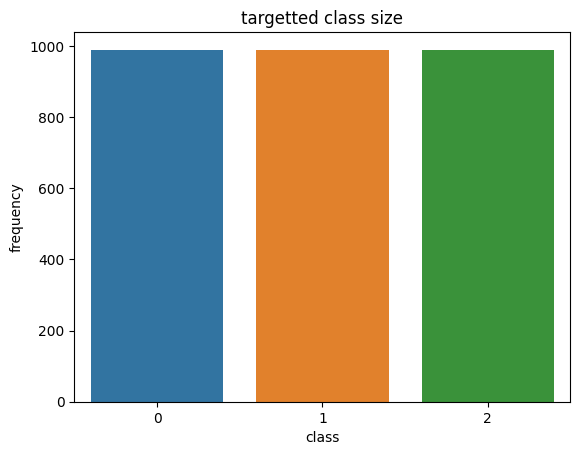

In [ ]:
# plot the DNA targets
targets = pd.DataFrame(DNA_targets_oversampled)
sns.countplot(targets, x=0)
plt.title('targetted class size')
plt.xlabel('class')
plt.ylabel('frequency')
plt.show()

### Split the Dataset into train and test data
here we will split the data into 80% training data and 20% test data

In [ ]:
# split data again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(DNA_features_oversampled, DNA_targets_oversampled, test_size = 0.20, random_state=42)

## Machine Learning Process

### NuSVC

In [ ]:
# from sklearn.svm import NuSVC
# from sklearn.model_selection import GridSearchCV

# # defining parameter range
# param_grid = {'nu': [0.1, 0.5, 0.9],
#                'gamma': [0.1, 0.01],
#                'kernel' : ['linear', 'rbf', 'poly']}

# grid = GridSearchCV(NuSVC(), param_grid, refit = True, verbose = 3, cv = 3)

# # fitting the model for grid search
# grid.fit(X_train, y_train)
# grid.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.922 total time=  39.0s
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.914 total time=  39.5s
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.1;, score=0.934 total time=  38.5s
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.895 total time= 1.2min
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.885 total time= 1.2min
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.5;, score=0.898 total time= 1.2min
[CV 1/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.655 total time= 1.5min
[CV 2/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.613 total time= 1.5min
[CV 3/3] END ..gamma=0.1, kernel=linear, nu=0.9;, score=0.699 total time= 1.5min
[CV 1/3] END .....gamma=0.1, kernel=rbf, nu=0.1;, score=0.923 total time=  37.7s
[CV 2/3] END .....gamma=0.1, kernel=rbf, nu=0.1;, score=0.918 total time=  38.2s
[CV 3/3] END .....gamma=0.1, kernel=rbf, nu=0.1;

{'gamma': 0.1, 'kernel': 'rbf', 'nu': 0.1}

In [ ]:
from sklearn.svm import NuSVC
cf = NuSVC(nu=0.3, gamma=0.1, kernel='linear')
cf.fit(X_train,y_train)
predicted = cf.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.88      0.97      0.93       192
           1       0.95      0.86      0.90       187
           2       0.98      0.97      0.98       215

    accuracy                           0.94       594
   macro avg       0.94      0.93      0.93       594
weighted avg       0.94      0.94      0.94       594



In [ ]:
from sklearn.svm import NuSVC
cf = NuSVC(nu=0.1, gamma=0.1, kernel='linear')
cf.fit(X_train,y_train)
predicted = cf.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       192
           1       0.96      0.87      0.91       187
           2       1.00      0.96      0.98       215

    accuracy                           0.94       594
   macro avg       0.95      0.94      0.94       594
weighted avg       0.95      0.94      0.94       594



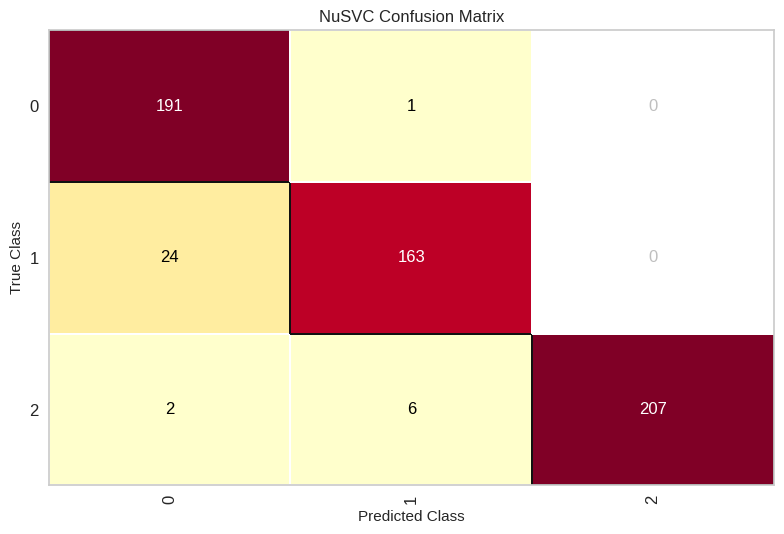

<Axes: title={'center': 'NuSVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# evaluation
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

cfmatrix = ConfusionMatrix(cf)

cfmatrix.fit(X_train, y_train)
cfmatrix.score(X_test, y_test)
cfmatrix.show()

In [ ]:
from sklearn.svm import NuSVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

# Assuming you have your dataset X and labels y

# Specify the number of splits and repeats
n_splits = 5  # Number of folds
n_repeats = 3  # Number of repeats

# Specify NuSVC parameters
gamma_value = 0.1
nu_value = 0.1

# Create a RepeatedStratifiedKFold object
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Initialize NuSVC with linear kernel and specified parameters
model = NuSVC(kernel='linear', gamma=gamma_value, nu=nu_value)

acc = []

# Perform repeated stratified cross-validation
for train_index, test_index in rskf.split(DNA_features_oversampled, DNA_targets_oversampled):
    X_train, X_test = DNA_features_oversampled[train_index], DNA_features_oversampled[test_index]
    y_train, y_test = DNA_targets_oversampled[train_index], DNA_targets_oversampled[test_index]

    # Train the NuSVC model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, predictions)
    acc.append(accuracy)
    print("Accuracy:", accuracy)

print(np.mean(acc))

Accuracy: 0.9410774410774411
Accuracy: 0.9377104377104377
Accuracy: 0.9325463743676222
Accuracy: 0.9426644182124789
Accuracy: 0.9359190556492412
Accuracy: 0.9377104377104377
Accuracy: 0.9208754208754208
Accuracy: 0.9510961214165261
Accuracy: 0.9409780775716695
Accuracy: 0.93929173693086
Accuracy: 0.9175084175084175
Accuracy: 0.9292929292929293
Accuracy: 0.93929173693086
Accuracy: 0.9359190556492412
Accuracy: 0.9443507588532883
0.936415494650458


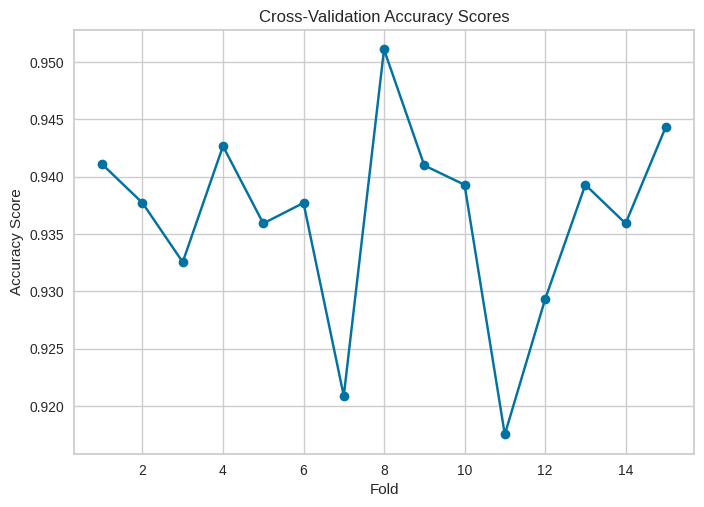

In [ ]:
# Plotting the accuracy scores
plt.plot(range(1, len(acc) + 1), acc, marker='o')
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.show()

### Train the Data

In [ ]:
# Using XGBoost
# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model = XGBClassifier(
    objective="multi:softmax",
    tree_method='hist',
    subsample=0.7,
    num_class=3,
    n_estimators=250,
    max_depth=15,
    learning_rate=0.01,
    colsample_bytree=0.6,
    colsample_bylevel=0.6,
    eval_metric='mlogloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [ ]:
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       192
           1       0.94      0.81      0.87       187
           2       0.92      1.00      0.96       215

    accuracy                           0.92       594
   macro avg       0.92      0.91      0.91       594
weighted avg       0.92      0.92      0.91       594



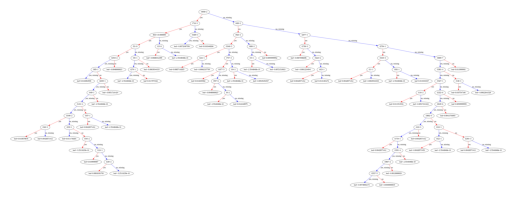

In [ ]:
from xgboost import plot_tree
# plot_tree(model, num_trees=3, rankdir='LR')
# plot_tree(model)
plot_tree(model, num_trees=0)
plt.rcParams['figure.figsize']=[5, 10]
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection, naive_bayes, svm

Naive = naive_bayes.MultinomialNB(alpha=1e-05)
Naive.fit(X_train,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test)

In [ ]:

param={'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
clf=GridSearchCV(Naive,param,scoring='accuracy',cv=10,return_train_score=True)
clf.fit(X_train, y_train);
clf.best_params_

{'alpha': 1e-05}

In [ ]:
print(classification_report(y_test, predictions_NB))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       192
           1       0.63      0.55      0.59       187
           2       0.67      0.76      0.71       215

    accuracy                           0.70       594
   macro avg       0.70      0.70      0.70       594
weighted avg       0.70      0.70      0.70       594



### Hyperparameter tunimgs

In [ ]:
# # hyperparameter tuning
# # estimate 30++ minutes
# params = {'max_depth': [3, 6, 10, 15],
#               'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
#               'subsample': np.arange(0.5, 1.0, 0.1),
#               'colsample_bytree': np.arange(0.5, 1.0, 0.1),
#               'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
#               'n_estimators': [100, 250, 500, 750],
#               'num_class': [3]
#               }

# xgbclf = XGBClassifier(objective="multi:softmax", tree_method='hist')
# clf = RandomizedSearchCV(estimator=xgbclf,
#                              param_distributions=params,
#                              scoring='accuracy',
#                              n_iter=25,
#                              n_jobs=4,
#                              verbose=1)
# clf.fit(X_train, y_train)
# best_combination = clf.best_params_
# print(best_combination)

In [ ]:
# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100],
#               'gamma': [1, 0.1, 0.01, 0.001],
#               'kernel' : ['linear', 'rbf', 'poly']}

# grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# # fitting the model for grid search
# grid.fit(X_train, y_train)
# grid.best_params_

In [ ]:
# from sklearn.model_selection import RepeatedStratifiedKFold

# cv_method = RepeatedStratifiedKFold(n_splits=5,
#                                     n_repeats=3,
#                                     random_state=999)

# from sklearn.preprocessing import PowerTransformer
# from sklearn.model_selection import GridSearchCV

# params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

# gs_NB = GridSearchCV(estimator=model,
#                      param_grid=params_NB,
#                      cv=cv_method,
#                      verbose=1,
#                      scoring='accuracy')
# Xtn = X_test.toarray()
# Data_transformed = PowerTransformer().fit_transform(Xtn)

# gs_NB.fit(Data_transformed, y_test);
# gs_NB.best_params_
# gs_NB.best_score_

In [ ]:
from sklearn import svm
cf = svm.SVC(C=1, gamma=0.1, kernel='linear')
cf.fit(X_train,y_train)
predicted = cf.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92       192
           1       0.90      0.83      0.86       187
           2       0.96      0.93      0.95       215

    accuracy                           0.91       594
   macro avg       0.91      0.91      0.91       594
weighted avg       0.91      0.91      0.91       594

